In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import uproot, os, logging, json, random, wandb, shap
import awkward as ak
# import torch
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, log_loss, classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GroupShuffleSplit, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
from matplotlib.ticker import FormatStrFormatter
from collections import Counter

# ML model
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Torch
import torch
import torch.nn as nn
import torch.optim as optim

# Config

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 14.0 # Use 14 point font
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 14
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],  # X and Y axis labels
    "xtick.labelsize": font_size["xticks"],  # X ticks
    "ytick.labelsize": font_size["yticks"],  # Y ticks
    "legend.fontsize": font_size["legend"]  # Legend
})

# Check for gpu
# torch.cuda.is_available()

In [48]:
df = pd.read_csv("/data/jlai/vertex/vertex_data.csv")
df.head(15)

,pv_z,ntracks,chi2,met,ph_pt,label,event_id
0,14.633709,55,5.306263e-04,105220.04,90286.820,0,349
1,18.741224,19,1.896872e-04,105220.04,90286.820,1,349
2,4.007279,68,2.364875e-03,105220.04,90286.820,0,349
3,-65.268240,61,3.028463e-05,127525.88,79554.450,1,471
4,50.357456,78,2.224994e-07,127525.88,79554.450,0,471
5,44.201930,58,2.650465e-08,127525.88,79554.450,0,471
6,21.377035,45,5.516303e-06,117685.59,89963.125,0,550
7,5.662861,51,1.033728e-05,117685.59,89963.125,1,550
8,4.461912,51,1.078336e-05,117685.59,89963.125,0,550
9,16.165080,58,2.603077e-04,119366.85,127403.586,0,710


In [17]:
# Data Preparation
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['event_id']))

df_train = df.iloc[train_idx].reset_index(drop=True)
df_test = df.iloc[test_idx].reset_index(drop=True)

X_train = df_train.drop(['label', 'event_id'], axis=1)
y_train = df_train['label'].values
X_test = df_test.drop(['label', 'event_id'], axis=1)
y_test = df_test['label'].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors 
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = Net(input_dim=X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Train
patience = 10
best_loss = float('inf')
patience_counter = 0

for epoch in range(1000):
    model.train()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_tensor)
        val_loss = criterion(val_pred, y_test_tensor)

    print(f"Epoch {epoch}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}")

    if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


model.load_state_dict(best_model_state)
model.eval()


Epoch 0: Train Loss = 0.7240, Val Loss = 0.7228
Epoch 1: Train Loss = 0.7223, Val Loss = 0.7211
Epoch 2: Train Loss = 0.7207, Val Loss = 0.7195
Epoch 3: Train Loss = 0.7190, Val Loss = 0.7179
Epoch 4: Train Loss = 0.7175, Val Loss = 0.7163
Epoch 5: Train Loss = 0.7159, Val Loss = 0.7147
Epoch 6: Train Loss = 0.7144, Val Loss = 0.7132
Epoch 7: Train Loss = 0.7129, Val Loss = 0.7117
Epoch 8: Train Loss = 0.7115, Val Loss = 0.7102
Epoch 9: Train Loss = 0.7100, Val Loss = 0.7088
Epoch 10: Train Loss = 0.7086, Val Loss = 0.7073
Epoch 11: Train Loss = 0.7072, Val Loss = 0.7059
Epoch 12: Train Loss = 0.7058, Val Loss = 0.7044
Epoch 13: Train Loss = 0.7044, Val Loss = 0.7030
Epoch 14: Train Loss = 0.7030, Val Loss = 0.7016
Epoch 15: Train Loss = 0.7017, Val Loss = 0.7002
Epoch 16: Train Loss = 0.7003, Val Loss = 0.6987
Epoch 17: Train Loss = 0.6989, Val Loss = 0.6973
Epoch 18: Train Loss = 0.6975, Val Loss = 0.6959
Epoch 19: Train Loss = 0.6962, Val Loss = 0.6945
Epoch 20: Train Loss = 0.6948,

VertexNet(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [18]:
# Predict probabilities and assign best candidate 
probs_test = model(X_test_tensor).detach().numpy().ravel()
df_test['prob'] = probs_test

best_candidates = df_test.loc[df_test.groupby('event_id')['prob'].idxmax()]
accuracy = (best_candidates['label'] == 1).mean()
print(f"Fraction of events where true PV was selected: {accuracy:.3f}")

Fraction of events where true PV was selected: 0.446


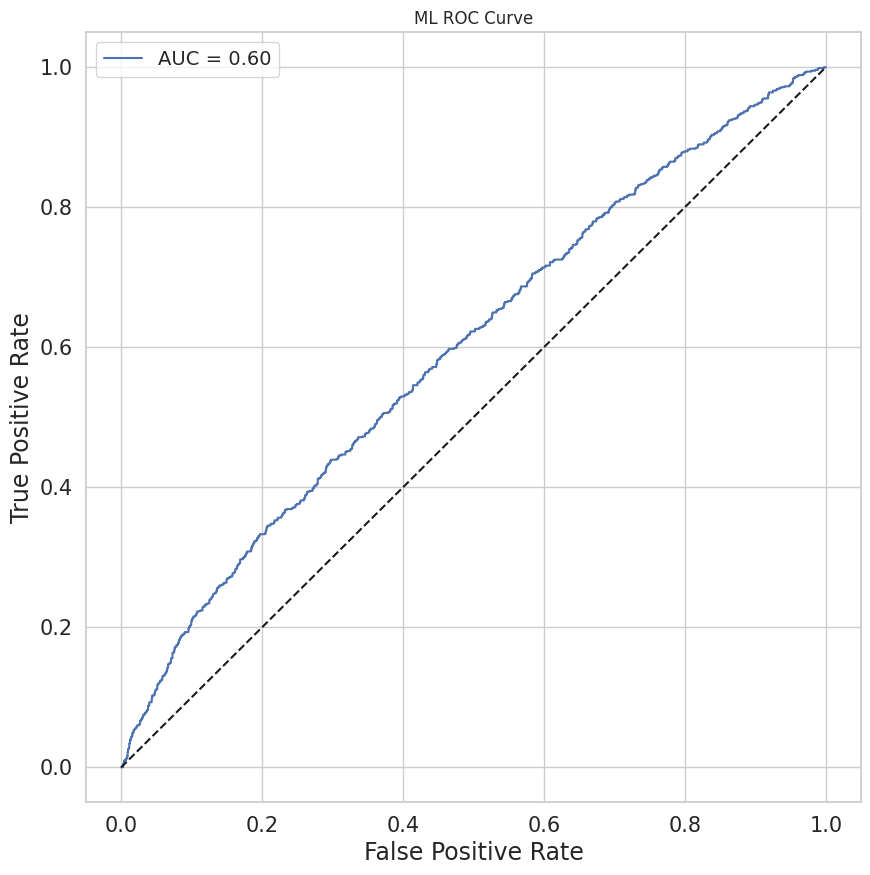

AttributeError: 'VertexNet' object has no attribute 'feature_importances_'

In [47]:
fpr, tpr, _ = roc_curve(y_test, probs_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ML ROC Curve")
plt.show()

Text(0.5, 1.0, 'Classifier Output for True vs. False PV Candidates')

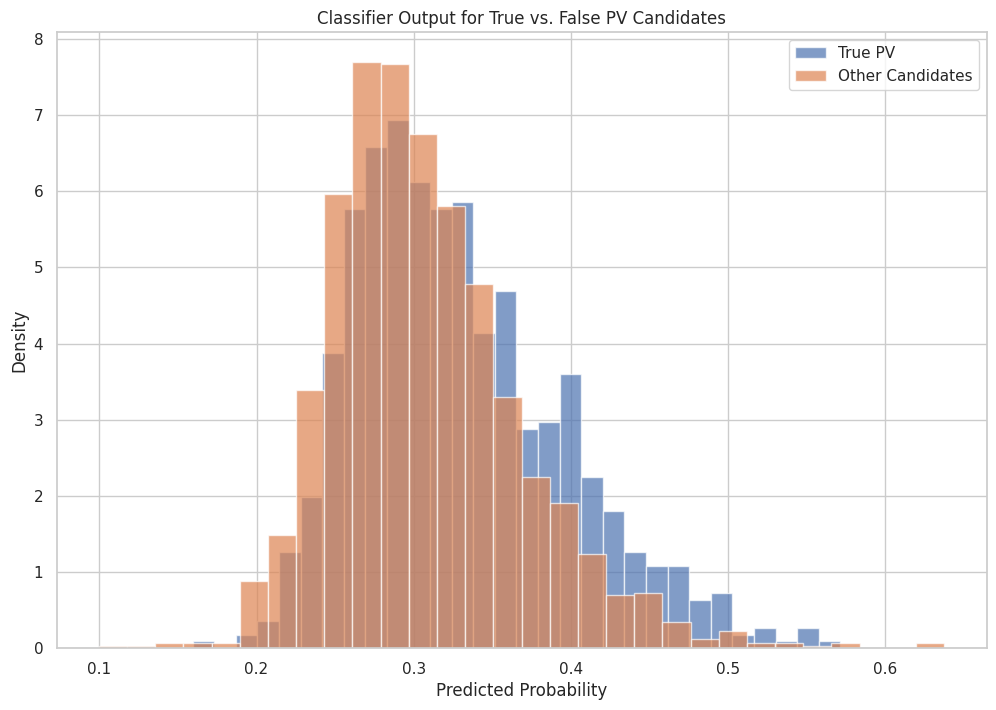

In [23]:
plt.hist(df_test[df_test['label'] == 1]['prob'], bins=30, alpha=0.7, label='True PV', density=True)
plt.hist(df_test[df_test['label'] == 0]['prob'], bins=30, alpha=0.7, label='Other Candidates', density=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.title('Classifier Output for True vs. False PV Candidates')
    

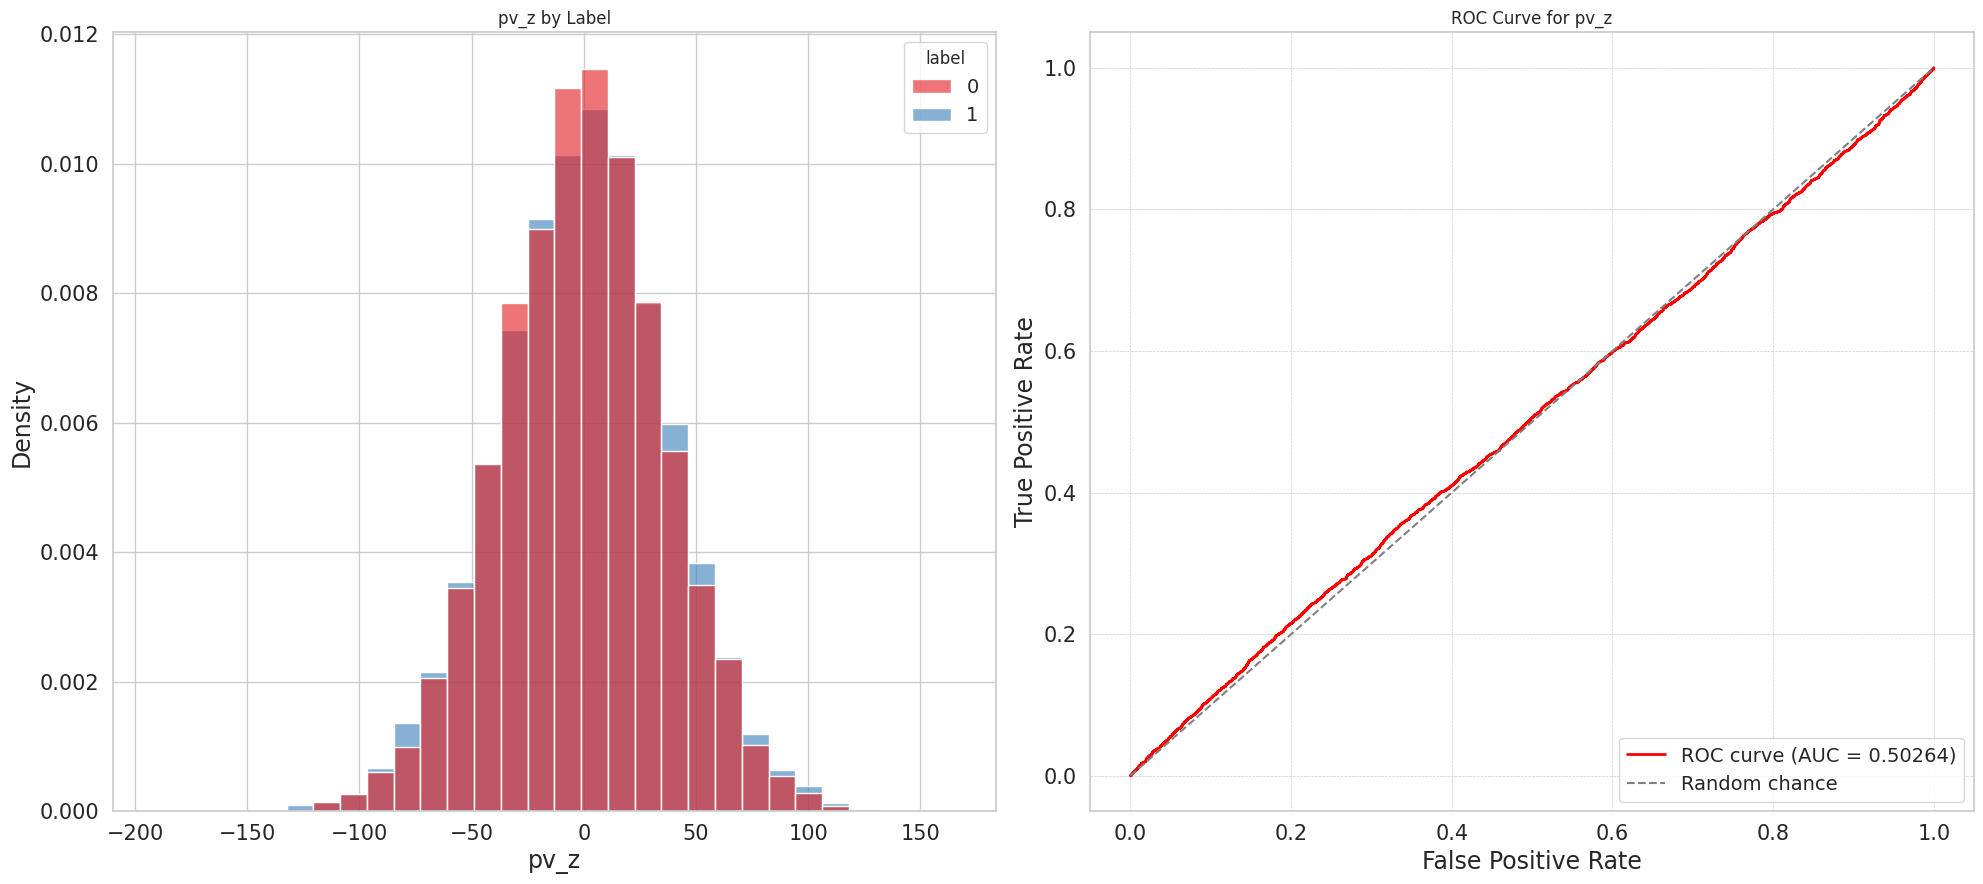

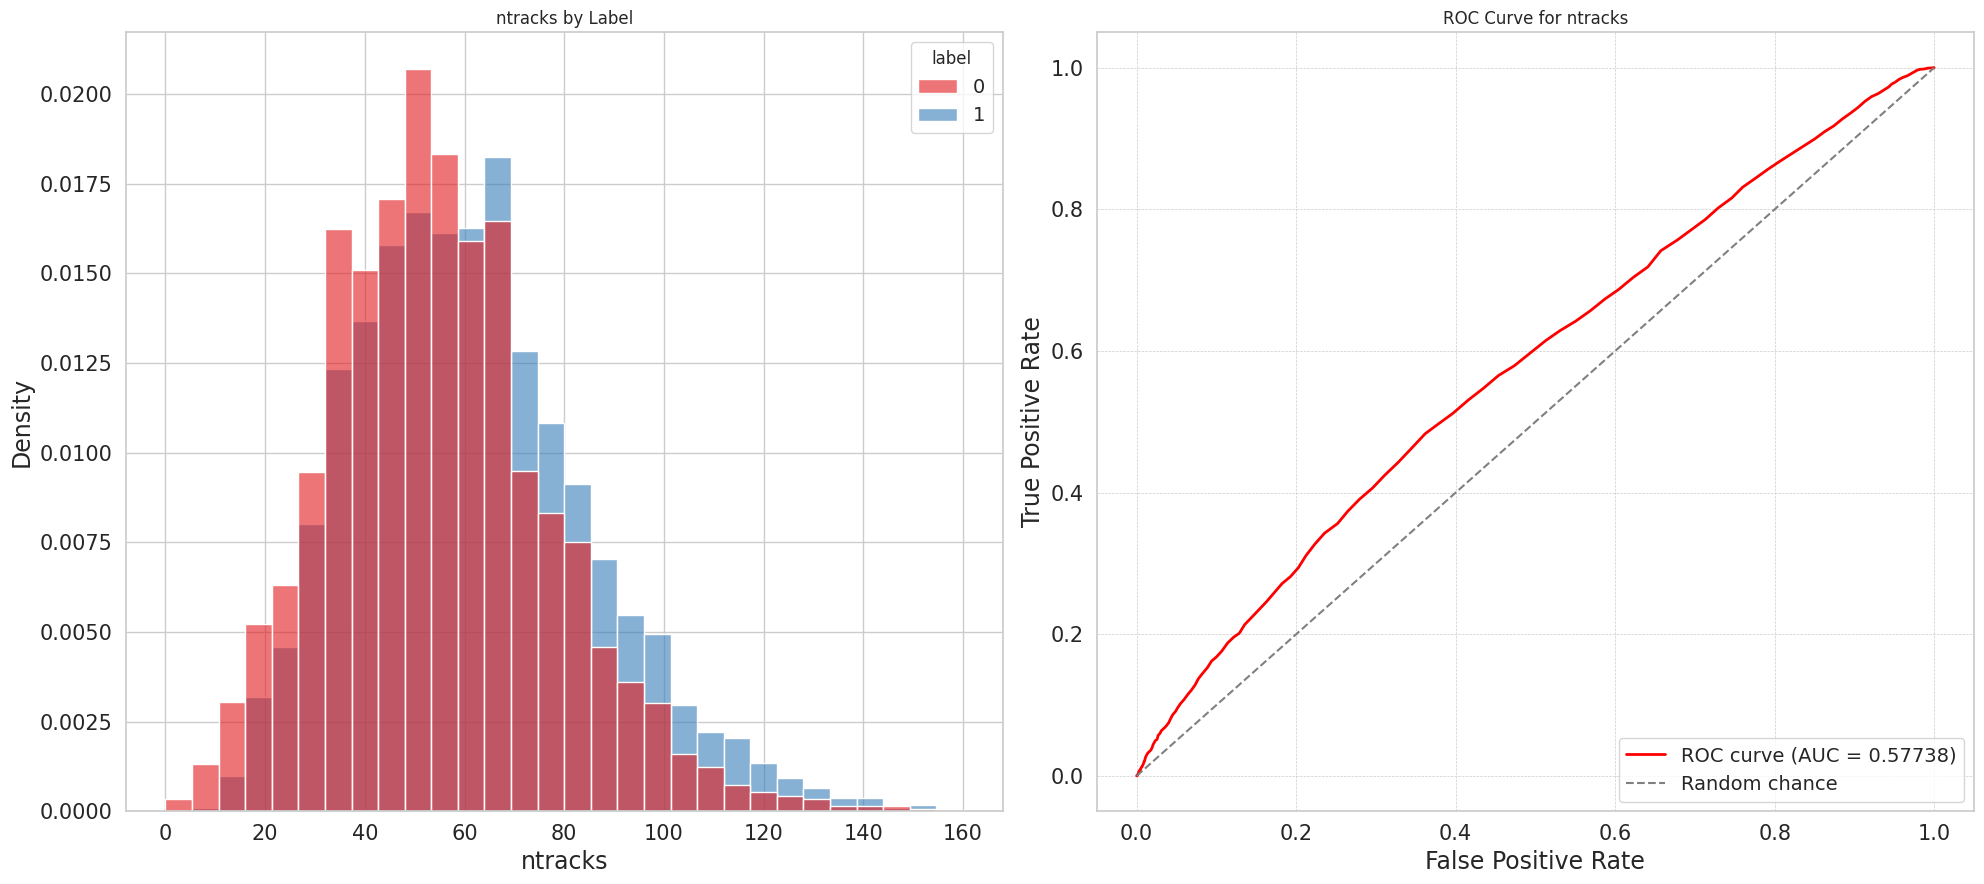

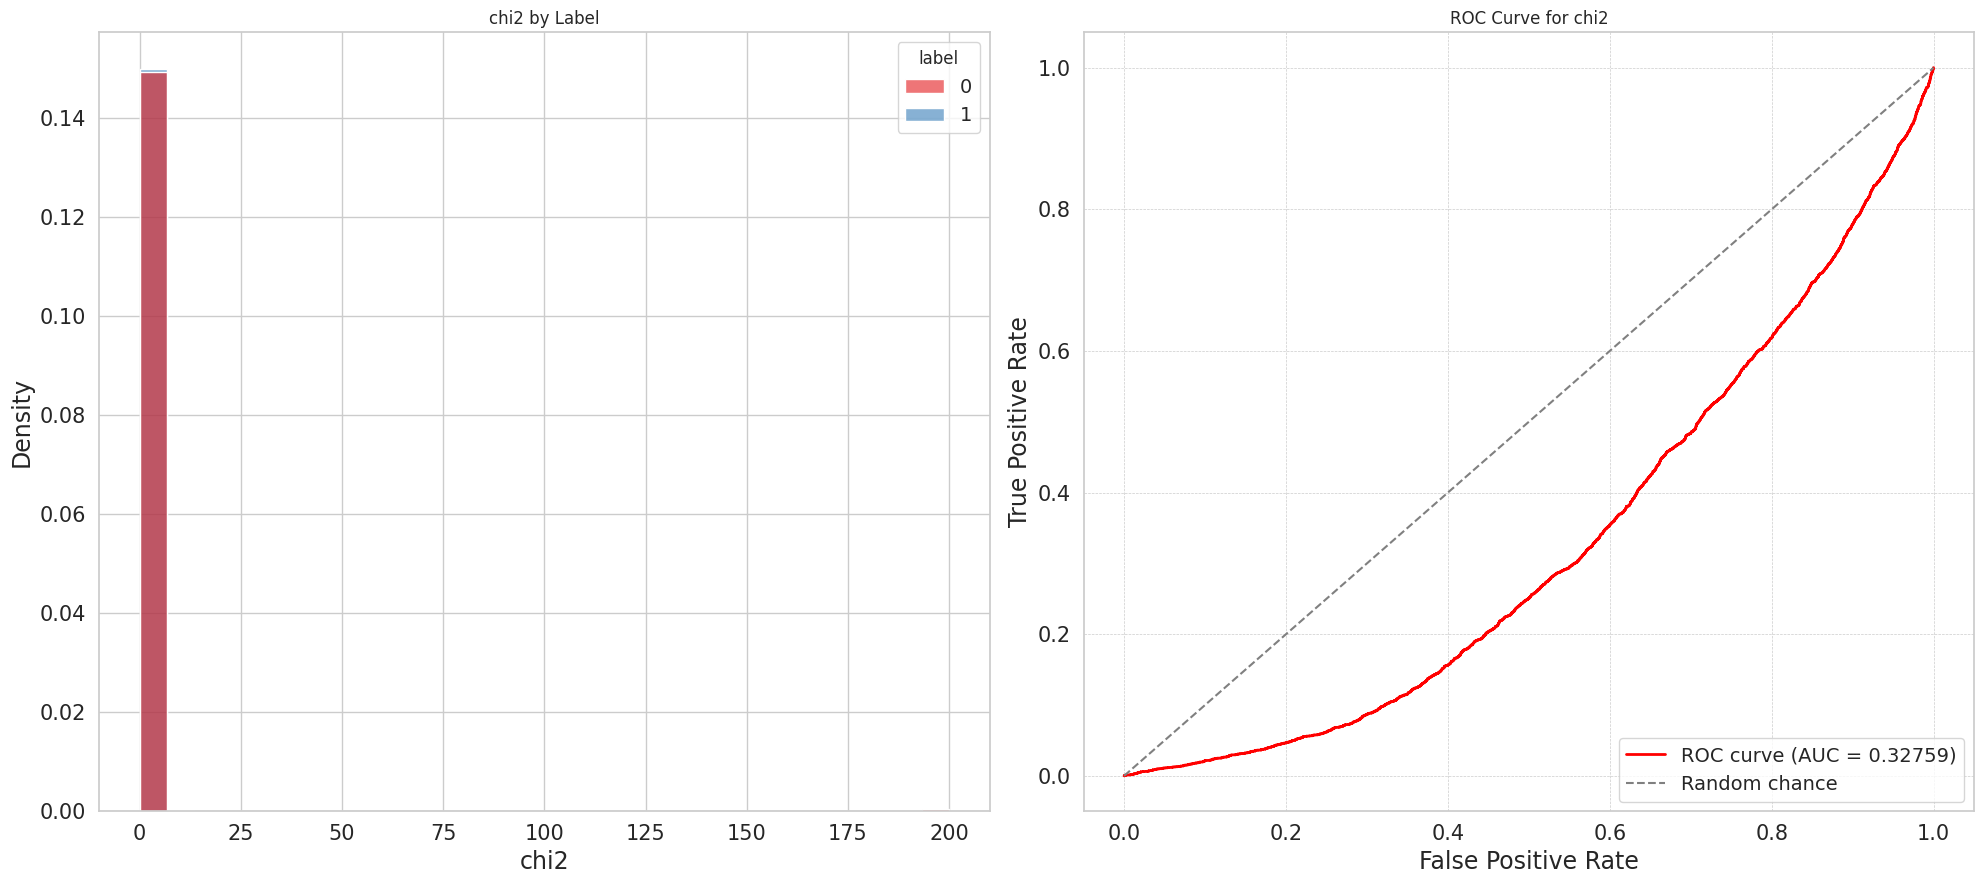

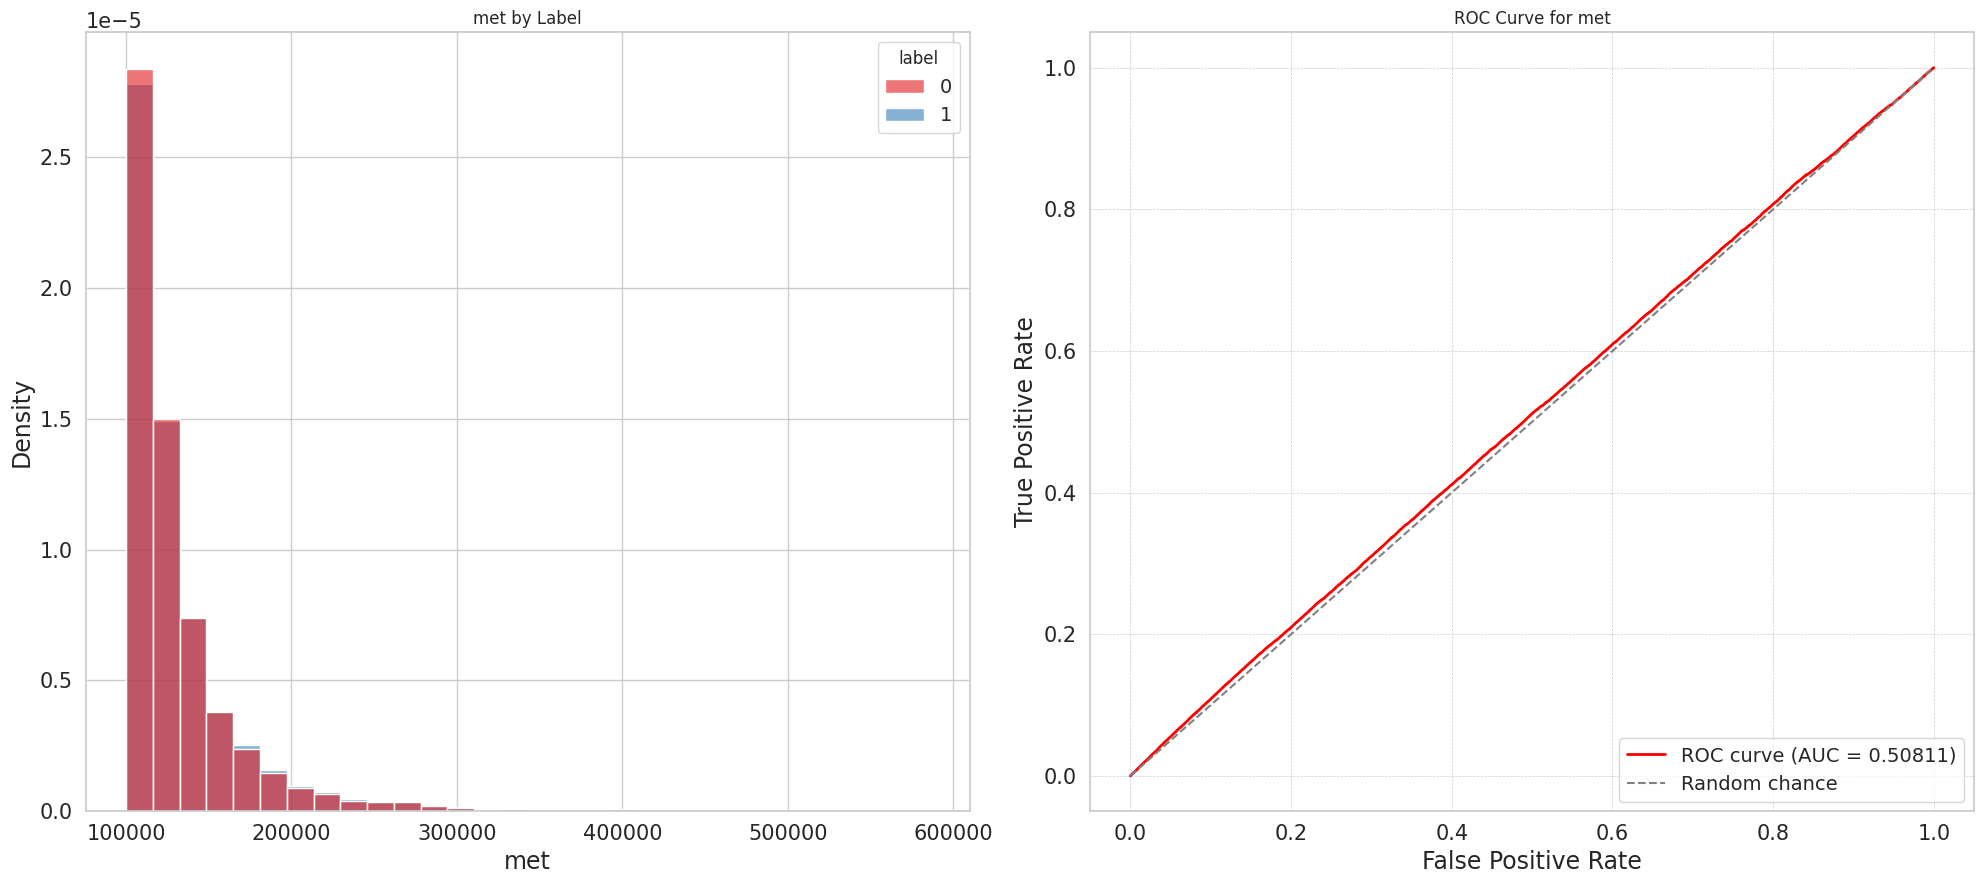

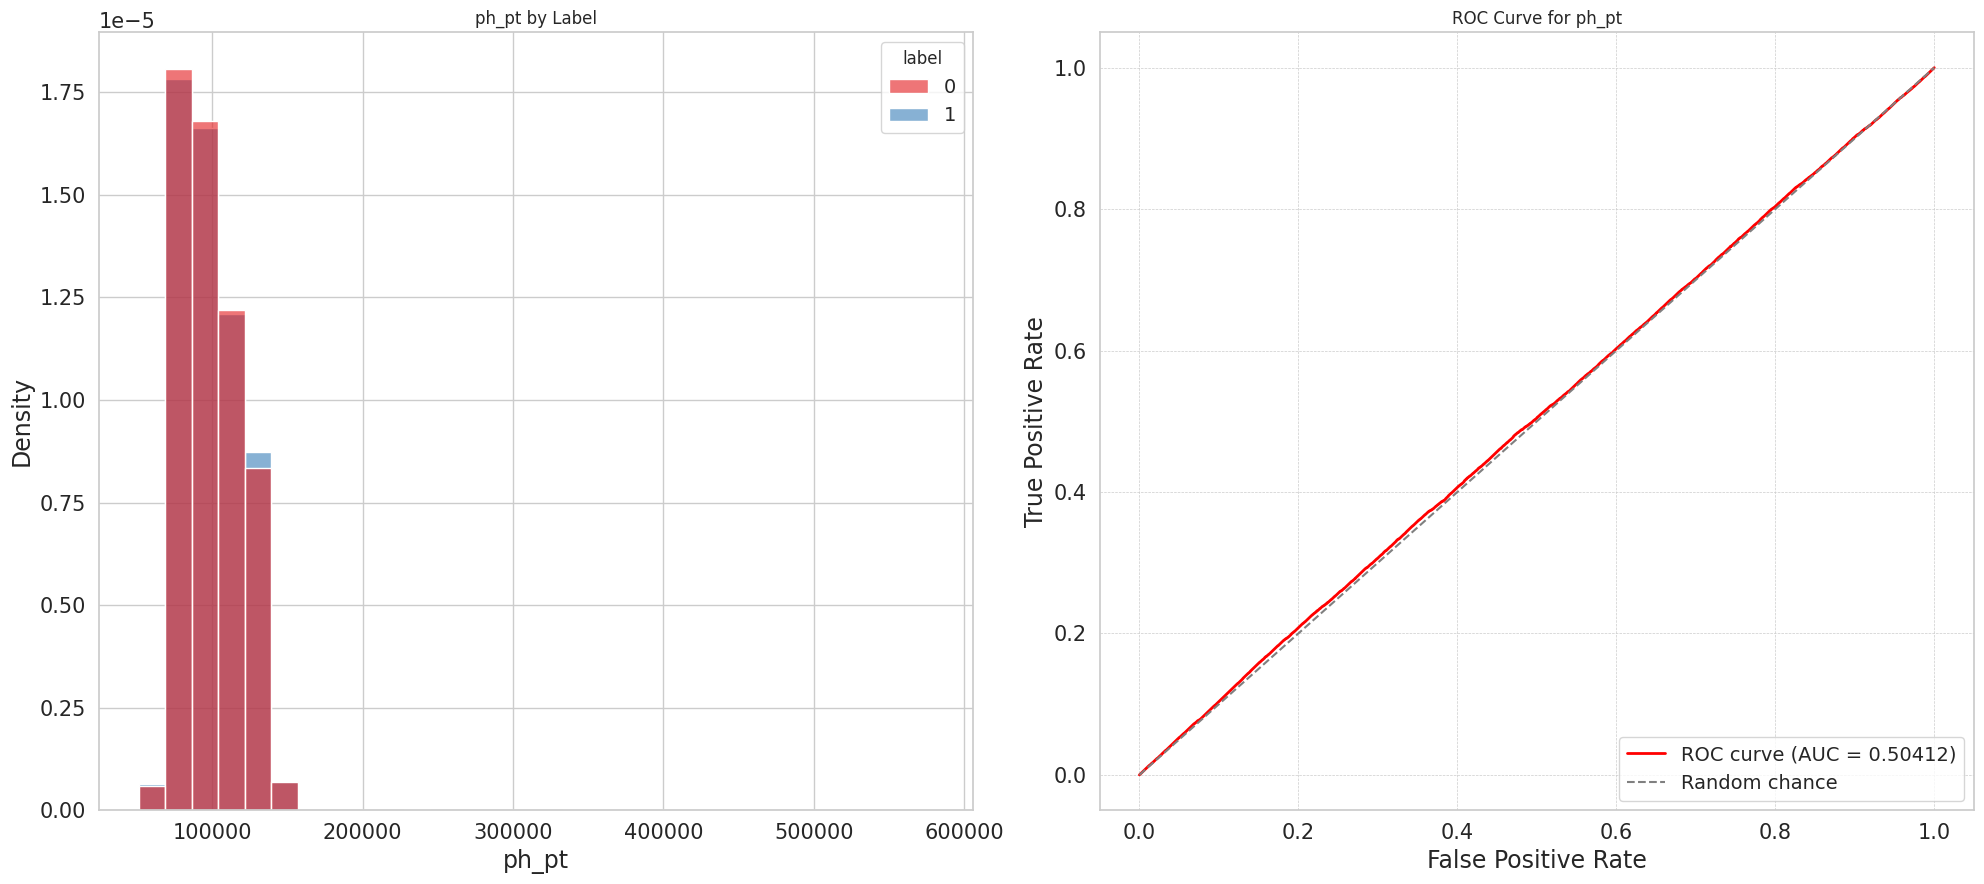

In [45]:
features_only = df.drop(columns=["label", "event_id"])

for col in features_only.columns:
    plt.figure(figsize=(20, 9))
    plt.subplot(121)
    sns.histplot(data=df, x=col, hue="label", bins=30, stat="density", common_norm=False, palette="Set1", alpha=0.6)
    plt.title(f"{col} by Label")

    plt.subplot(122)
    fpr, tpr, thresholds = roc_curve(df.label, df[col])
    sorted_indices = np.argsort(fpr)
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]

    roc_auc = auc(fpr_sorted, tpr_sorted)
    
    plt.plot(fpr, tpr, lw=2, color='red', label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random chance')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {col}")
    plt.legend(loc="lower right")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()    